<a href="https://colab.research.google.com/github/Wooshaw/ESE_527_Project/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import datetime as dt
import copy
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from collections import Counter
import time

In [ ]:
def compute_rsi(data, window=14):
    delta = data.diff()
    delta = delta.dropna()

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = -down.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def norm(a, b, result):

    min_vals = np.min(result, 0)
    max_vals = np.max(result, 0)
    result - min_vals
    # Avoid division by zero in case max and min are the same
    result = a + ((result - min_vals) / (max_vals - min_vals + np.finfo(float).eps)) * (b - a)

    return result

def preprocessing(stock):

    stock.reset_index(inplace=True) # Make date no longer an Index
    stock['1d_Close'] = stock['Close'].shift(1)
    stock['3d_Close'] = stock['Close'].shift(3)
    stock['7d_Close'] = stock['Close'].shift(7)

    stock['RSI'] = compute_rsi(stock['Close'])

    stock['SMA'] = stock['Close'].rolling(window=20).mean()
    stock['STD'] = stock['Close'].rolling(window=20).std()
    stock['Upper_BB'] = stock['SMA'] + (stock['STD'] * 2)
    stock['Lower_BB'] = stock['SMA'] - (stock['STD'] * 2)
    stock = stock.iloc[19:,:]
    # df_BRK = df_BRK.drop(['Date'], axis=1)

    stock['Target'] = stock['Close']
    stock = stock.drop(['Close'], axis=1)

    window_size = 15
    stock['moving_avg'] = stock['Target'].rolling(window=window_size).mean()
    stock['moving_std'] = stock['Target'].rolling(window=window_size).std()

    stock['Date'] = stock['Date'].dt.date
    stock.set_index('Date', inplace=True)

    # Decompose the time series into trend, seasonal, and residual components
    decomposition = sm.tsa.seasonal_decompose(stock['Target'], model='additive', period=5)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Identify outliers in the residuals
    threshold = 2
    residual_std = residual.std()
    stock["outlier"] = (residual > threshold * residual_std) | (residual < -threshold * residual_std)
    # print(dict(Counter(TSD_frame['outlier']).items()))

    stock.reset_index(inplace=True)
    outliers = stock[stock['outlier']==True]

    # def handle_outliers(x):
    #   if x["outlier"] == True:
    #     return x["moving_avg"]
    #   else:
    #     return x["Target"]
    # df_BRK['Target']=df_BRK.apply(lambda row:handle_outliers(row),axis=1)

    stock = stock.drop(['Date'], axis=1)
    stock = stock.drop(['moving_avg'], axis=1)
    stock = stock.drop(['moving_std'], axis=1)
    stock = stock.drop(['outlier'], axis=1)
    stock = stock.drop(['Dividends', 'Stock Splits', 'Volume', 'Upper_BB', 'Lower_BB','3d_Close', '7d_Close', 'Open', 'STD'], axis=1)

    return stock

def generate_data(stock_df):
    rolling_obj = stock_df.rolling(window=15)
    arrays = [window.values for window in rolling_obj if len(window) == 15]
    result = np.array(arrays)

    input_feature = []
    label = []
    key = []
    last_day = []

    for i in range(0, result.shape[0]):
        trans = result[i]
        target = trans[:, -1]
        feature = trans[:-1, :]
        # print(feature.shape)
        feature = norm(0, 1, feature)
        min_t = target[:-1].min()
        max_t = target[:-1].max()
        if max_t != min_t and np.isnan(feature).any() == False:
            t = (target[-1]-min_t)/(max_t-min_t)
            input_feature.append(feature)
            label.append(t)
            last_day.append((target[-2]-min_t)/(max_t-min_t))
            key.append([min_t, max_t])

    input_feature = np.array(input_feature)
    label = np.array(label)
    key = np.array(key)
    last_day = np.array(last_day)

    input_feature = torch.tensor(input_feature, dtype=torch.float32)
    label = torch.tensor(label, dtype=torch.float32)
    last_day = torch.tensor(last_day, dtype=torch.float32)

    train_size = int(input_feature.shape[0] * 0.8)

    train_feature, train_label, train_last_day = input_feature[:train_size], label[:train_size], last_day[:train_size]
    test_feature, test_label, test_key, test_last_day = input_feature[train_size:], label[train_size:], key[train_size:], last_day[train_size:]

    return train_feature, train_label, train_last_day, test_feature, test_label, test_key, test_last_day

In [ ]:
# Training Data
df_BRK = yf.Ticker("BRK-A").history(period="max")
df_AVGO = yf.Ticker("AVGO").history(period="max")
df_LULU = yf.Ticker("LULU").history(period="max")
df_DOCU = yf.Ticker("DOCU").history(period="max")
df_RH = yf.Ticker("RH").history(period="max")
df_GOOG = yf.Ticker("GOOG").history(period="max")
df_GOOGL = yf.Ticker("GOOGL").history(period="max")
df_GDHG = yf.Ticker("GDHG").history(period="max")
df_AMD = yf.Ticker("AMD").history(period="max")
df_MBI = yf.Ticker("MBI").history(period="max")


# Testing Data
df_CAVA = yf.Ticker("CAVA").history(period="max")
df_JBLU = yf.Ticker("JBLU").history(period="max")
df_HCP = yf.Ticker("HCP").history(period="max")
df_SLDB = yf.Ticker("SLDB").history(period="max")
df_AAPL = yf.Ticker("AAPL").history(period="max")

In [ ]:
df_BRK = preprocessing(df_BRK)
df_AVGO = preprocessing(df_AVGO)
df_LULU = preprocessing(df_LULU)
df_DOCU = preprocessing(df_DOCU)
df_RH = preprocessing(df_RH)
df_GOOG = preprocessing(df_GOOG)
df_GOOGL = preprocessing(df_GOOGL)
df_GDHG = preprocessing(df_GDHG)
df_AMD = preprocessing(df_AMD)
df_MBI = preprocessing(df_MBI)

df_CAVA = preprocessing(df_CAVA)
df_JBLU = preprocessing(df_JBLU)
df_HCP = preprocessing(df_HCP)
df_SLDB = preprocessing(df_SLDB)
df_AAPL = preprocessing(df_AAPL)

<ipython-input-2-bfe64847870c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['Target'] = stock['Close']
<ipython-input-2-bfe64847870c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['Target'] = stock['Close']
<ipython-input-2-bfe64847870c>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

3 folds validation

In [ ]:
train_stock1 = [df_BRK, df_AVGO, df_LULU, df_DOCU, df_RH, df_GOOG, df_GOOGL, df_GDHG, df_AMD, df_MBI]
test_stock1 = [df_CAVA, df_JBLU, df_HCP, df_SLDB, df_AAPL]

train_stock2 = [df_BRK, df_AVGO, df_LULU, df_DOCU, df_RH, df_CAVA, df_JBLU, df_HCP, df_SLDB, df_AAPL]
test_stock2 = [df_GOOG, df_GOOGL, df_GDHG, df_AMD, df_MBI]

train_stock3 = [df_CAVA, df_JBLU, df_HCP, df_SLDB, df_AAPL, df_GOOG, df_GOOGL, df_GDHG, df_AMD, df_MBI]
test_stock3 = [df_BRK, df_AVGO, df_LULU, df_DOCU, df_RH]

train_stock = train_stock1
test_stock = test_stock1

In [ ]:
train_feature_all = torch.zeros(0, 14, 6)
train_label_all = torch.zeros(0)
train_last_day_all = torch.zeros(0)
val_feature_all = torch.zeros(0, 14, 6)
val_label_all = torch.zeros(0)
val_key_all = np.zeros((0, 2))
val_last_day_all = torch.zeros(0)
test_feature_all = torch.zeros(0, 14, 6)
test_label_all = torch.zeros(0)
test_key_all = np.zeros((0, 2))
test_last_day_all = torch.zeros(0)

for i in train_stock:
      train_feature, train_label, train_last_day, val_feature, val_label, val_key, val_last_day = generate_data(i)

      train_feature_all = torch.cat([train_feature_all, train_feature], dim=0)
      train_label_all = torch.cat([train_label_all, train_label], dim=0)
      train_last_day_all = torch.cat([train_last_day_all, train_last_day], dim=0)
      val_feature_all = torch.cat([val_feature_all, val_feature], dim=0)
      val_label_all = torch.cat([val_label_all, val_label], dim=0)
      val_key_all = np.append(val_key_all, val_key, axis=0)
      val_last_day_all = torch.cat([val_last_day_all, val_last_day], dim=0)

for i in test_stock:
      train_feature, train_label, train_last_day, test_feature, test_label, test_key, test_last_day = generate_data(i)

      test_feature_all = torch.cat([test_feature_all, test_feature], dim=0)
      test_label_all = torch.cat([test_label_all, test_label], dim=0)
      test_key_all = np.append(test_key_all, test_key, axis=0)
      test_last_day_all = np.append(test_last_day_all, test_last_day, axis=0)

      print(len(test_key))

18
1085
94
289
2162


In [ ]:
train_feature.shape

torch.Size([8644, 14, 6])

In [ ]:
train_dataset = TensorDataset(train_feature_all, train_last_day_all, train_label_all)
val_dataset = TensorDataset(val_feature_all, val_last_day_all, val_label_all)
test_dataset = TensorDataset(test_feature_all, test_label_all)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
class StockPriceLSTM(nn.Module):
    def __init__(self):
        super(StockPriceLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=6, hidden_size=50, num_layers=2, batch_first=True)
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x[:, -1, :])
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.get_device_name(0)
torch.cuda.set_device(0)

model = StockPriceLSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):
    total_loss = 0
    for inputs, last_day_label, targets in train_loader:
        outputs = model(inputs.to(device))
#         print(targets)
        loss = criterion(outputs, targets.view(-1,1).to(device))
#         print(loss.item())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.view(-1,1).to(device))
            total_loss += loss.item()
        print(f'Test Loss: {total_loss / len(test_loader)}')

Epoch 1, Loss: 0.18838262872057074
Test Loss: 0.10060943747841354
Epoch 2, Loss: 0.10772873919123166
Test Loss: 0.0933227930838439
Epoch 3, Loss: 0.09939062949496472
Test Loss: 0.0895005167960189
Epoch 4, Loss: 0.09768253844372905
Test Loss: 0.08450814069360178
Epoch 5, Loss: 0.09503396630774062
Test Loss: 0.08328859619643961
Epoch 6, Loss: 0.09454032501041618
Test Loss: 0.08299681210913824
Epoch 7, Loss: 0.0928962147769187
Test Loss: 0.08236270978601022
Epoch 8, Loss: 0.09202067139006494
Test Loss: 0.08091203247759123
Epoch 9, Loss: 0.09148728657842226
Test Loss: 0.08141435012361904
Epoch 10, Loss: 0.09112542242839321
Test Loss: 0.08167863099574213
Epoch 11, Loss: 0.09106037678412164
Test Loss: 0.08047505513677806
Epoch 12, Loss: 0.09059693398786352
Test Loss: 0.07964691467446998
Epoch 13, Loss: 0.09068203219679669
Test Loss: 0.08111771729680246
Epoch 14, Loss: 0.0905931340601284
Test Loss: 0.08003814951188767
Epoch 15, Loss: 0.09038965864174951
Test Loss: 0.08094283032657494
Epoch 16

In [ ]:
start = time.time()
with torch.no_grad():
    pred = []
    real = []
    last_day = []
    for inputs, targets in test_loader:
        outputs = model(inputs.to(device))

        pred.append(outputs[0,0].detach().to("cpu").item())
        real.append(targets[0].detach().to("cpu").item())

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_real.append(value)
print(time.time()-start)

1.9389512538909912


In [ ]:
len(inputs[0,-1,:])

6

In [ ]:
real = np.array(real)
pred = np.array(pred)
inv_real = np.array(inv_real)
inv_pred = np.array(inv_pred)

In [ ]:
bin_ground_truth = []
bin_pred = []
for i in range(0, len(test_last_day_all)):
    # print(real[i], test_last_day_all[i])
    if real[i]>=test_last_day_all[i]:
        bin_ground_truth.append(1)
    else:
        bin_ground_truth.append(0)

    if pred[i]>=test_last_day_all[i]:
        bin_pred.append(1)
    else:
        bin_pred.append(0)

test_last_day_all.shape, real.shape

((3648,), (3648,))

col_0,0,1
row_0,,
0,0.252772,0.747228
1,0.273319,0.726681


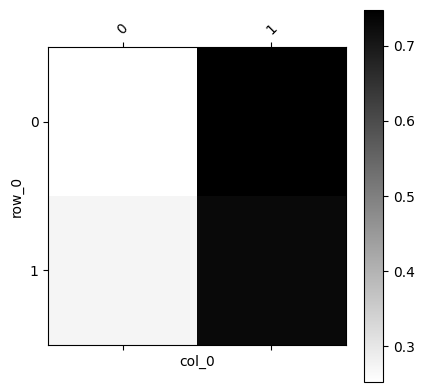

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

df_confusion = pd.crosstab(bin_ground_truth, bin_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")

plot_confusion_matrix(df_conf_norm)
df_conf_norm

In [ ]:
print("Test Loss:", ((inv_pred - inv_real)**2).mean())

Test Loss: 2.1311686958593627


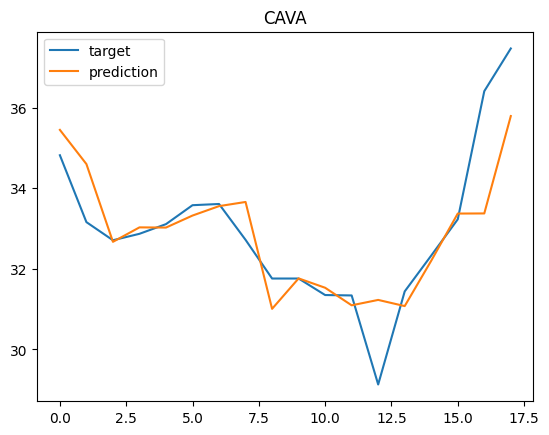

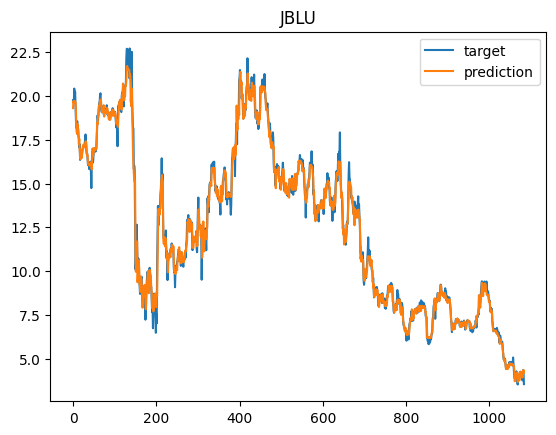

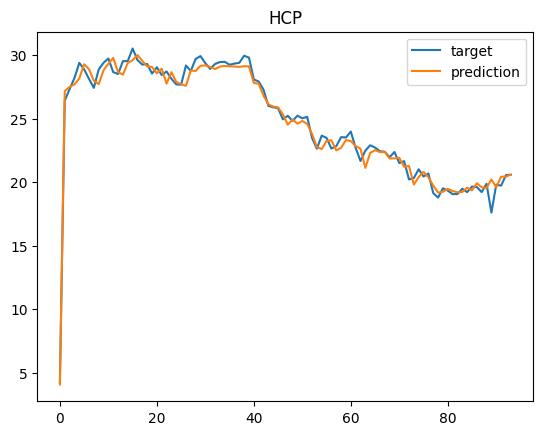

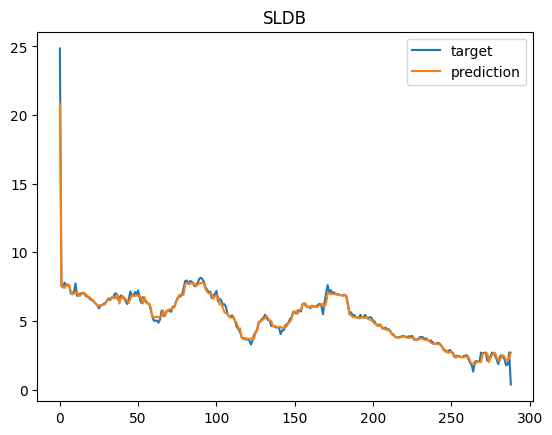

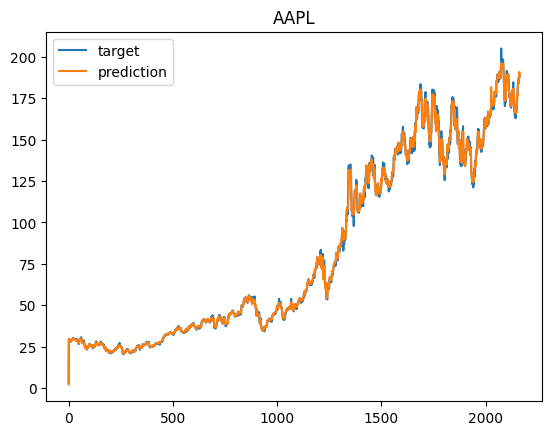

In [ ]:
x = range(len(inv_pred[:18]))
plt.plot(x,inv_real[:18], label="target")
plt.plot(x,inv_pred[:18], label="prediction")
plt.title('CAVA')
plt.legend()
plt.show()

x = range(len(inv_pred[18:18+1084]))
plt.plot(x,inv_real[18:18+1084], label="target")
plt.plot(x,inv_pred[18:18+1084], label="prediction")
plt.title('JBLU')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084:18+1084+94]))
plt.plot(x,inv_real[18+1084:18+1084+94], label="target")
plt.plot(x,inv_pred[18+1084:18+1084+94], label="prediction")
plt.title('HCP')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94:18+1084+94+289]))
plt.plot(x,inv_real[18+1084+94:18+1084+94+289], label="target")
plt.plot(x,inv_pred[18+1084+94:18+1084+94+289], label="prediction")
plt.title('SLDB')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94+289:]))
plt.plot(x,inv_real[18+1084+94+289:], label="target")
plt.plot(x,inv_pred[18+1084+94+289:], label="prediction")
plt.title('AAPL')
plt.legend()
plt.show()
# df_CAVA, df_JBLU, df_HCP, df_SLDB, df_AAPL

Baselines

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Linear regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.svm import SVR

X = train_feature_all.numpy()  # Simulating the input data
y = train_label_all.numpy()          # Simulating the ground truth labels

X_reshaped = X.reshape(X.shape[0], 14*6)

model = LinearRegression()

model.fit(X_reshaped, y)

LinearRegression()

In [ ]:
new_data_reshaped = test_feature_all.numpy().reshape(test_feature_all.shape[0], 14*6)

# Use the model to predict
start = time.time()
pred = model.predict(new_data_reshaped)

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_real.append(value)
print(time.time()-start)
pred = np.array(pred)
inv_real = np.array(inv_real)
inv_pred = np.array(inv_pred)

0.01360177993774414


col_0,0,1
row_0,,
0,0.259978,0.740022
1,0.248373,0.751627


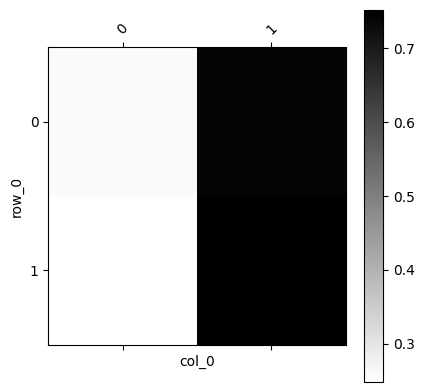

In [ ]:
bin_ground_truth = []
bin_pred = []
for i in range(0, len(test_last_day_all)):
    # print(real[i], test_last_day_all[i])
    if real[i]>=test_last_day_all[i]:
        bin_ground_truth.append(1)
    else:
        bin_ground_truth.append(0)

    if pred[i]>=test_last_day_all[i]:
        bin_pred.append(1)
    else:
        bin_pred.append(0)

df_confusion = pd.crosstab(bin_ground_truth, bin_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")

plot_confusion_matrix(df_conf_norm)
df_conf_norm

In [ ]:
print("Test Loss:", ((inv_pred - inv_real)**2).mean())

Test Loss: 2.1010270044361867


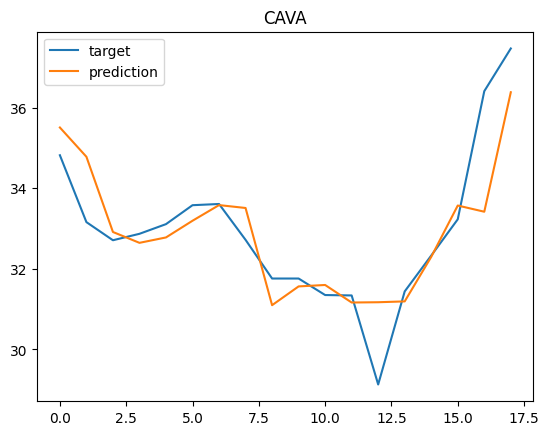

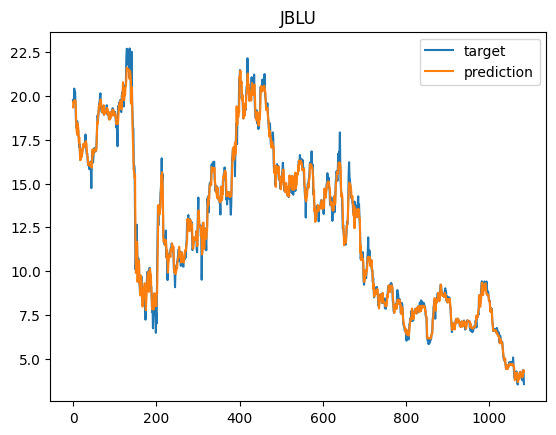

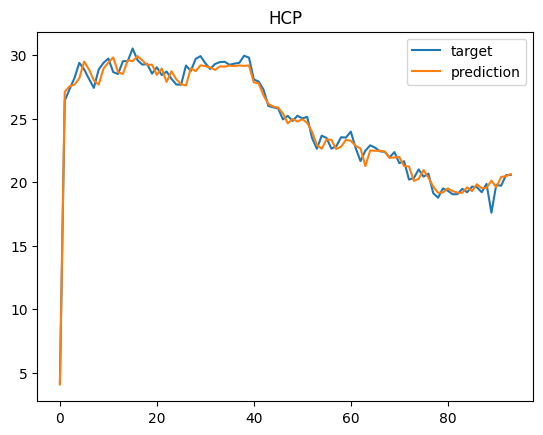

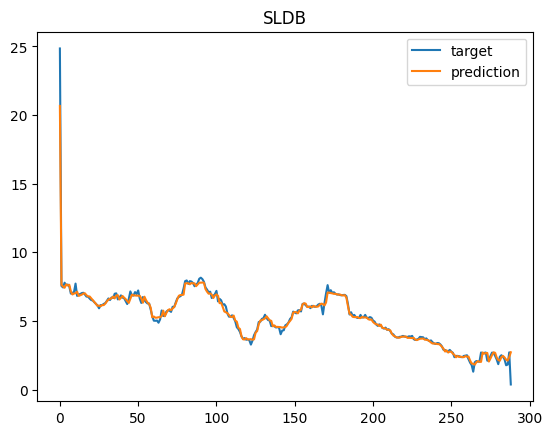

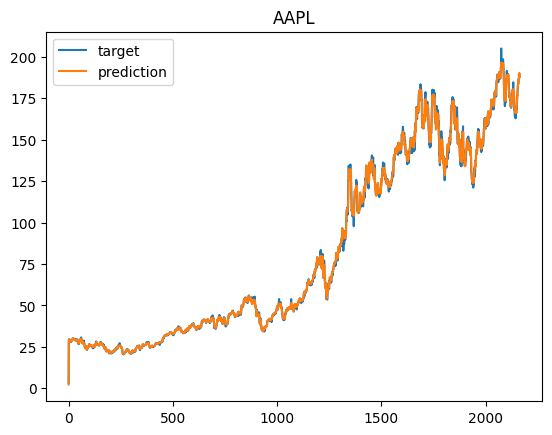

In [ ]:
x = range(len(inv_pred[:18]))
plt.plot(x,inv_real[:18], label="target")
plt.plot(x,inv_pred[:18], label="prediction")
plt.title('CAVA')
plt.legend()
plt.show()

x = range(len(inv_pred[18:18+1084]))
plt.plot(x,inv_real[18:18+1084], label="target")
plt.plot(x,inv_pred[18:18+1084], label="prediction")
plt.title('JBLU')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084:18+1084+94]))
plt.plot(x,inv_real[18+1084:18+1084+94], label="target")
plt.plot(x,inv_pred[18+1084:18+1084+94], label="prediction")
plt.title('HCP')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94:18+1084+94+289]))
plt.plot(x,inv_real[18+1084+94:18+1084+94+289], label="target")
plt.plot(x,inv_pred[18+1084+94:18+1084+94+289], label="prediction")
plt.title('SLDB')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94+289:]))
plt.plot(x,inv_real[18+1084+94+289:], label="target")
plt.plot(x,inv_pred[18+1084+94+289:], label="prediction")
plt.title('AAPL')
plt.legend()
plt.show()

SVM

In [ ]:
svr_model = SVR(kernel='rbf')

# Train the model
svr_model.fit(X_reshaped, y)

SVR()

In [ ]:
new_data_reshaped = test_feature_all.numpy().reshape(test_feature_all.shape[0], 14*6)

start = time.time()
# Use the model to predict
pred = svr_model.predict(new_data_reshaped)

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_real.append(value)

print(time.time()-start)
pred = np.array(pred)
inv_real = np.array(inv_real)
inv_pred = np.array(inv_pred)

9.778809547424316


col_0,0,1
row_0,,
0,0.460643,0.539357
1,0.410521,0.589479


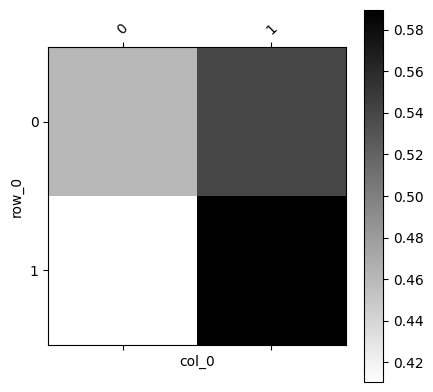

In [ ]:
bin_ground_truth = []
bin_pred = []
for i in range(0, len(test_last_day_all)):
    # print(real[i], test_last_day_all[i])
    if real[i]>=test_last_day_all[i]:
        bin_ground_truth.append(1)
    else:
        bin_ground_truth.append(0)

    if pred[i]>=test_last_day_all[i]:
        bin_pred.append(1)
    else:
        bin_pred.append(0)

df_confusion = pd.crosstab(bin_ground_truth, bin_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")

plot_confusion_matrix(df_conf_norm)
df_conf_norm

In [ ]:
print("Test Loss:", ((inv_pred - inv_real)**2).mean())

Test Loss: 2.1511269189654327


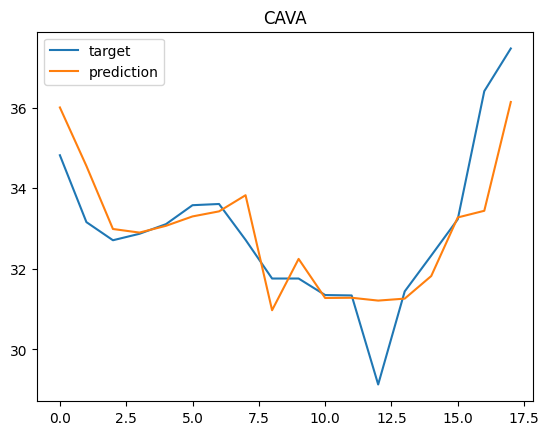

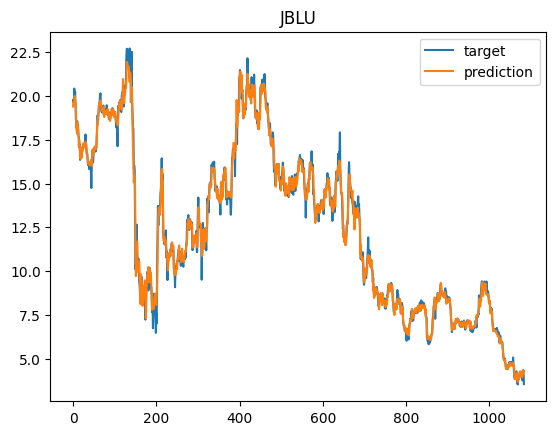

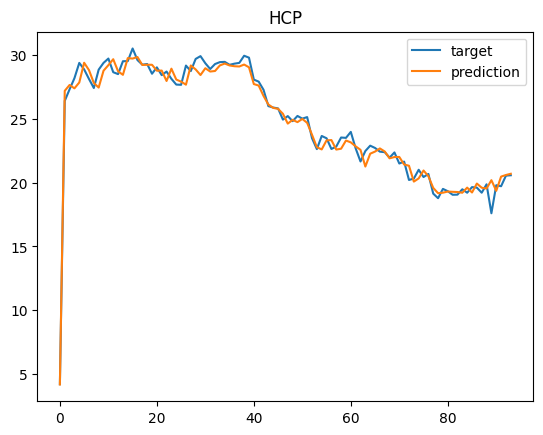

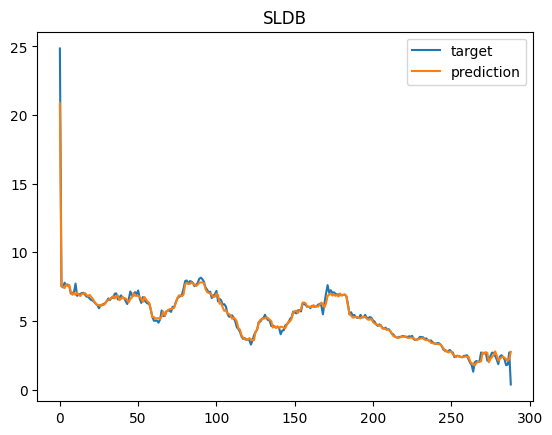

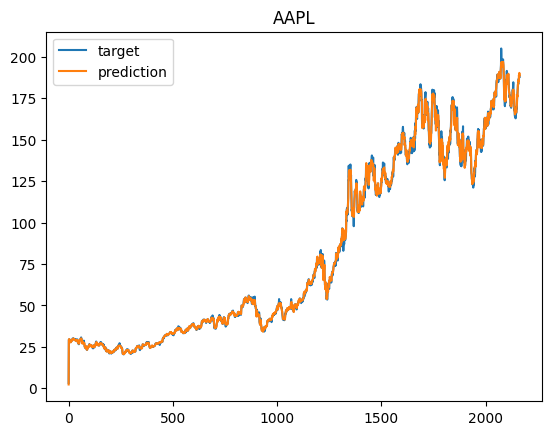

In [ ]:
x = range(len(inv_pred[:18]))
plt.plot(x,inv_real[:18], label="target")
plt.plot(x,inv_pred[:18], label="prediction")
plt.title('CAVA')
plt.legend()
plt.show()

x = range(len(inv_pred[18:18+1084]))
plt.plot(x,inv_real[18:18+1084], label="target")
plt.plot(x,inv_pred[18:18+1084], label="prediction")
plt.title('JBLU')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084:18+1084+94]))
plt.plot(x,inv_real[18+1084:18+1084+94], label="target")
plt.plot(x,inv_pred[18+1084:18+1084+94], label="prediction")
plt.title('HCP')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94:18+1084+94+289]))
plt.plot(x,inv_real[18+1084+94:18+1084+94+289], label="target")
plt.plot(x,inv_pred[18+1084+94:18+1084+94+289], label="prediction")
plt.title('SLDB')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94+289:]))
plt.plot(x,inv_real[18+1084+94+289:], label="target")
plt.plot(x,inv_pred[18+1084+94+289:], label="prediction")
plt.title('AAPL')
plt.legend()
plt.show()

Xgboost

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
new_data_reshaped = test_feature_all.numpy().reshape(test_feature_all.shape[0], 14*6)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# Train the model
xg_reg.fit(X_reshaped, y)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [ ]:
start = time.time()
pred = xg_reg.predict(new_data_reshaped)

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_real.append(value)

print(time.time()-start)
pred = np.array(pred)
inv_real = np.array(inv_real)
inv_pred = np.array(inv_pred)

0.013292551040649414


col_0,0,1
row_0,,
0,0.507761,0.492239
1,0.508134,0.491866


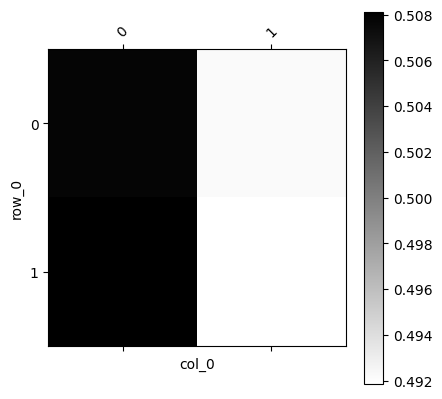

In [ ]:
bin_ground_truth = []
bin_pred = []
for i in range(0, len(test_last_day_all)):
    # print(real[i], test_last_day_all[i])
    if real[i]>=test_last_day_all[i]:
        bin_ground_truth.append(1)
    else:
        bin_ground_truth.append(0)

    if pred[i]>=test_last_day_all[i]:
        bin_pred.append(1)
    else:
        bin_pred.append(0)

df_confusion = pd.crosstab(bin_ground_truth, bin_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")

plot_confusion_matrix(df_conf_norm)
df_conf_norm

In [ ]:
print("Test Loss:", ((inv_pred - inv_real)**2).mean())

Test Loss: 3.318491991906791


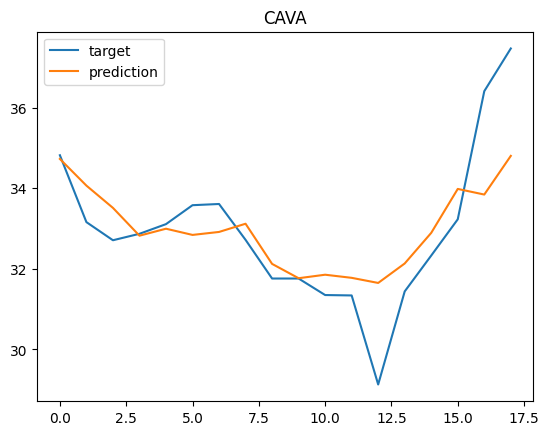

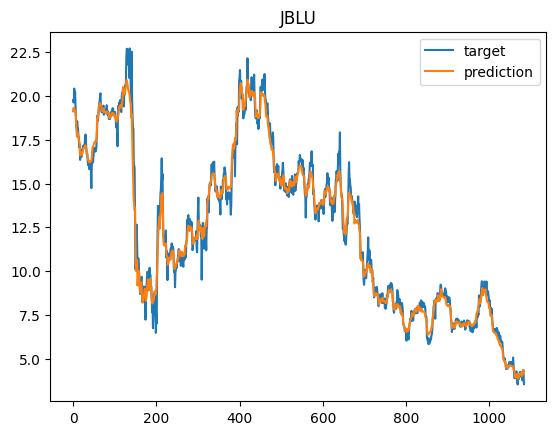

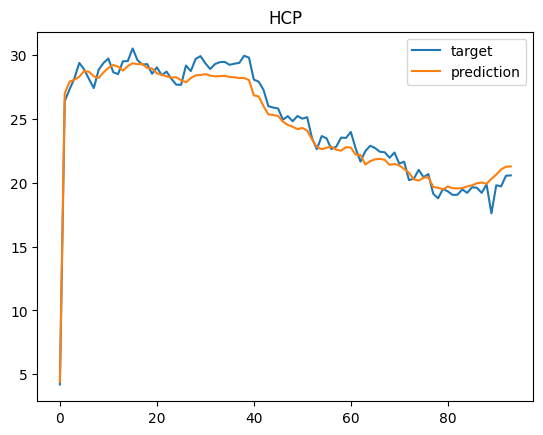

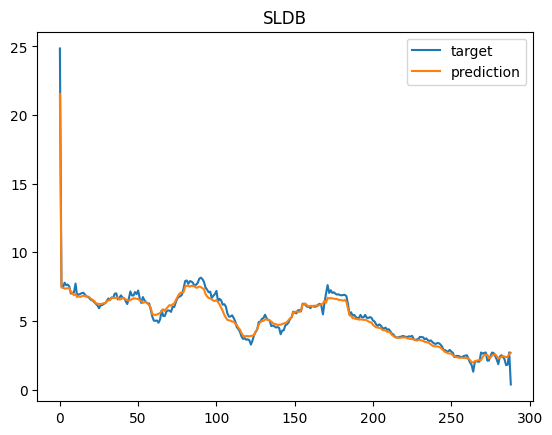

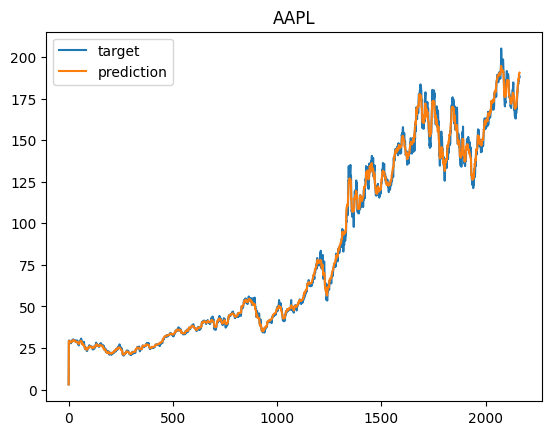

In [ ]:
x = range(len(inv_pred[:18]))
plt.plot(x,inv_real[:18], label="target")
plt.plot(x,inv_pred[:18], label="prediction")
plt.title('CAVA')
plt.legend()
plt.show()

x = range(len(inv_pred[18:18+1084]))
plt.plot(x,inv_real[18:18+1084], label="target")
plt.plot(x,inv_pred[18:18+1084], label="prediction")
plt.title('JBLU')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084:18+1084+94]))
plt.plot(x,inv_real[18+1084:18+1084+94], label="target")
plt.plot(x,inv_pred[18+1084:18+1084+94], label="prediction")
plt.title('HCP')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94:18+1084+94+289]))
plt.plot(x,inv_real[18+1084+94:18+1084+94+289], label="target")
plt.plot(x,inv_pred[18+1084+94:18+1084+94+289], label="prediction")
plt.title('SLDB')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94+289:]))
plt.plot(x,inv_real[18+1084+94+289:], label="target")
plt.plot(x,inv_pred[18+1084+94+289:], label="prediction")
plt.title('AAPL')
plt.legend()
plt.show()

RandomForest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, max_depth=10, random_state=42)

# Train the model
rf.fit(X_reshaped, y)

RandomForestRegressor(max_depth=10, n_estimators=10, random_state=42)

In [ ]:
new_data_reshaped = test_feature_all.numpy().reshape(test_feature_all.shape[0], 14*6)

In [ ]:
start = time.time()
pred = rf.predict(new_data_reshaped)

inv_pred = []
inv_real = []
for i in range(0, len(pred)):
    value = pred[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_pred.append(value)
    value = real[i]*(test_key_all[i,0]-test_key_all[i,1])+test_key_all[i,1]
    inv_real.append(value)

print(time.time()-start)
pred = np.array(pred)
inv_real = np.array(inv_real)
inv_pred = np.array(inv_pred)

0.012764692306518555


col_0,0,1
row_0,,
0,0.288803,0.711197
1,0.300434,0.699566


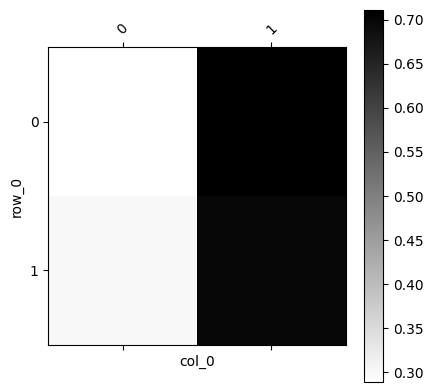

In [ ]:
bin_ground_truth = []
bin_pred = []
for i in range(0, len(test_last_day_all)):
    # print(real[i], test_last_day_all[i])
    if real[i]>=test_last_day_all[i]:
        bin_ground_truth.append(1)
    else:
        bin_ground_truth.append(0)

    if pred[i]>=test_last_day_all[i]:
        bin_pred.append(1)
    else:
        bin_pred.append(0)

df_confusion = pd.crosstab(bin_ground_truth, bin_pred)
df_conf_norm = df_confusion.div(df_confusion.sum(axis=1), axis="index")

plot_confusion_matrix(df_conf_norm)
df_conf_norm

In [ ]:
print("Test Loss:", ((inv_pred - inv_real)**2).mean())

Test Loss: 2.1640528546282605


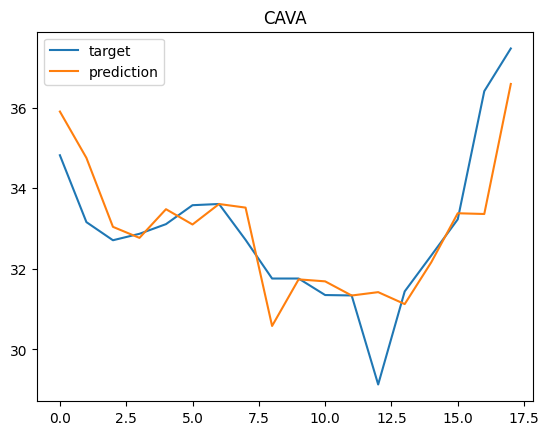

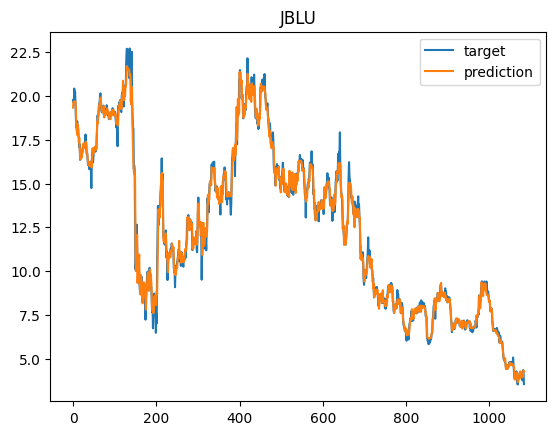

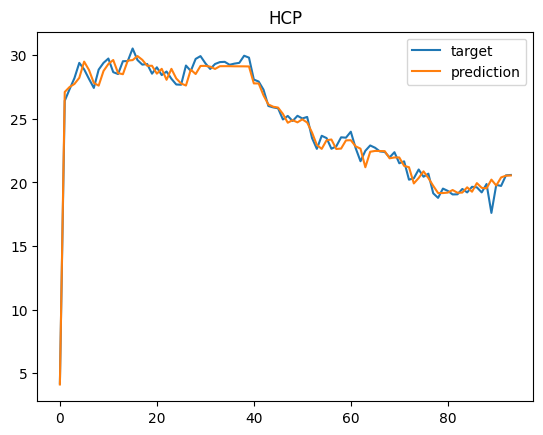

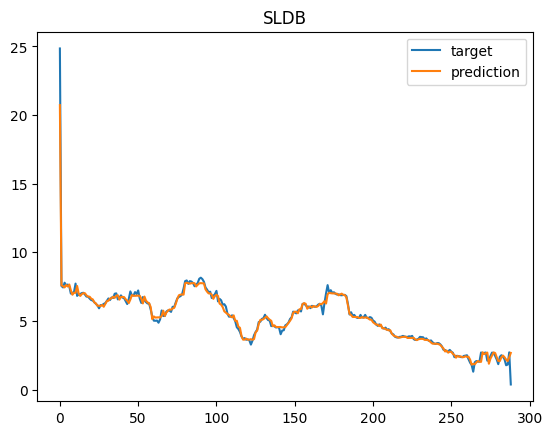

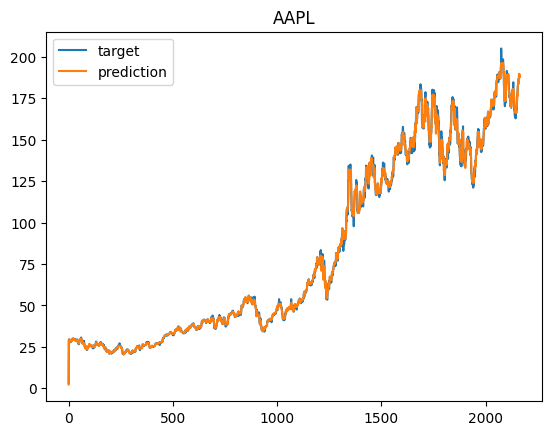

In [ ]:
x = range(len(inv_pred[:18]))
plt.plot(x,inv_real[:18], label="target")
plt.plot(x,inv_pred[:18], label="prediction")
plt.title('CAVA')
plt.legend()
plt.show()

x = range(len(inv_pred[18:18+1084]))
plt.plot(x,inv_real[18:18+1084], label="target")
plt.plot(x,inv_pred[18:18+1084], label="prediction")
plt.title('JBLU')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084:18+1084+94]))
plt.plot(x,inv_real[18+1084:18+1084+94], label="target")
plt.plot(x,inv_pred[18+1084:18+1084+94], label="prediction")
plt.title('HCP')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94:18+1084+94+289]))
plt.plot(x,inv_real[18+1084+94:18+1084+94+289], label="target")
plt.plot(x,inv_pred[18+1084+94:18+1084+94+289], label="prediction")
plt.title('SLDB')
plt.legend()
plt.show()

x = range(len(inv_pred[18+1084+94+289:]))
plt.plot(x,inv_real[18+1084+94+289:], label="target")
plt.plot(x,inv_pred[18+1084+94+289:], label="prediction")
plt.title('AAPL')
plt.legend()
plt.show()